# Learning Rate scheduling in pytorch

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import numpy as np

### Preparing DataLoaders

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=16)
test_dataloader = DataLoader(test_data, batch_size=16)
# # Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"

100%|██████████| 26.4M/26.4M [00:18<00:00, 1.40MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 152kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.69MB/s]
100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]


In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

### Exponential learning rate decay

In [4]:
learning_rate = 1e-3
batch_size = 16
epochs = 5

# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

decayRate = 0.96
exp_decay_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

### Defining Training and Testing Loop

In [5]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = []
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            train_loss.append(loss)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    exp_decay_lr_scheduler.step()
    return np.average(train_loss)

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

### Model training

In [6]:
train_losses, val_losses = [], []

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    avg_train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    avg_test_loss = test_loop(test_dataloader, model, loss_fn)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_test_loss)

print("Done!")


Epoch 1
-------------------------------
loss: 2.299750  [    0/60000]
loss: 2.288007  [ 1600/60000]
loss: 2.284567  [ 3200/60000]
loss: 2.266864  [ 4800/60000]
loss: 2.262115  [ 6400/60000]
loss: 2.249012  [ 8000/60000]
loss: 2.222714  [ 9600/60000]
loss: 2.204840  [11200/60000]
loss: 2.209761  [12800/60000]
loss: 2.175430  [14400/60000]
loss: 2.169753  [16000/60000]
loss: 2.149850  [17600/60000]
loss: 2.136507  [19200/60000]
loss: 2.117780  [20800/60000]
loss: 2.113198  [22400/60000]
loss: 2.048277  [24000/60000]
loss: 2.010254  [25600/60000]
loss: 2.093750  [27200/60000]
loss: 1.976246  [28800/60000]
loss: 1.971360  [30400/60000]
loss: 1.854783  [32000/60000]
loss: 1.820587  [33600/60000]
loss: 1.716433  [35200/60000]
loss: 1.831032  [36800/60000]
loss: 1.880657  [38400/60000]
loss: 1.671282  [40000/60000]
loss: 1.645874  [41600/60000]
loss: 1.725422  [43200/60000]
loss: 1.456807  [44800/60000]
loss: 1.546247  [46400/60000]
loss: 1.623062  [48000/60000]
loss: 1.389457  [49600/60000]


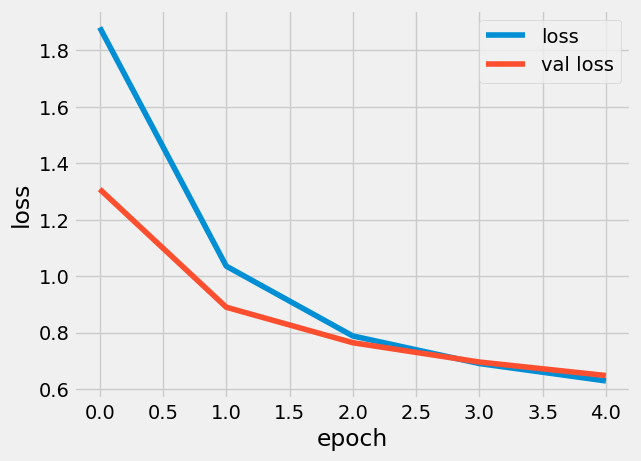

In [7]:
#loss plot
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.plot(train_losses,label='loss')
plt.plot(val_losses,label='val loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()